# Heart Attack - Kaggle competition

Author: _Aniko Maraz, PhD_

<div class="alert alert-block alert-info">
    
This is an <a href="https://www.kaggle.com/competitions/heart-attack-risk-analysis/overview">active Kaggle competition</a>  for Kudos. <br>    
The task is to predict (on an unseen dataset) if the patient is at low or high risk of heart attack. The train data consists of 26 potential features. Luckily, the dataset contains no missing data or noteworthy outliers. <br>

In the current notebook I will preprocess the data, attempt to fit an XGBoost model (which performs better than SVM), and fine-tune the hyperparameters. The final model had an accuracy of 0.7541. Besides fine-tuning the parameters, feature selection also improved fit and left us with a nicely interpretable model! <br>

Note that this is the first version of my data science model which got me to place 56 in the competition. I will further tune the model - I am sure I can do better. 

</div>

__Table of Contents__

![img](submission/toc.png)

## Imports

In [53]:
import numpy as np
import pandas as pd
from dataprep.eda import create_report

from matplotlib import pyplot as plt
import seaborn as sns

import statistics
from scipy.stats import uniform

# scikit-learn == 1.2.2 was installed

from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    RobustScaler,
    OrdinalEncoder,
    LabelEncoder,
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

import joblib

import jupyter_black
import warnings

%load_ext jupyter_black
%matplotlib inline

warnings.filterwarnings("ignore")  # for final notebook

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [49]:
# Display all columns in the DataFrame throughout the Notebook
pd.set_option("display.max_columns", None)

## DATA: GET AND EXPLORE

In [50]:
df_raw_train = pd.read_csv("data/train.csv")

Here is the first 5 rows of the data: 

In [51]:
df_raw_train.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,RDG0550,33,Male,200,129/90,48,0,1,1,1,1,7.807690,Unhealthy,0,1,2,0.138443,184066,30.449815,63,6,7,Argentina,South America,Southern Hemisphere,1
1,NMA3851,56,Female,262,159/105,46,1,0,1,0,0,17.297628,Average,1,0,8,0.369552,211755,34.973685,333,7,8,Nigeria,Africa,Northern Hemisphere,1
2,TUI5807,19,Female,140,161/109,54,0,1,0,0,1,8.695288,Average,1,1,3,8.646334,252203,30.554246,537,2,10,Thailand,Asia,Northern Hemisphere,0
3,YYT5016,50,Female,163,120/62,53,0,1,1,1,1,10.161587,Healthy,0,1,7,1.107884,121954,35.390265,591,0,9,Spain,Europe,Southern Hemisphere,1
4,ZAC5937,89,Female,144,153/110,92,1,0,1,0,1,16.436787,Healthy,1,0,1,1.337570,180121,39.575483,145,2,5,Germany,Europe,Northern Hemisphere,1


Let's see the data more in details (i.e. mean and distribution). 

In [52]:
report = create_report(df_raw_train)
# report.save('report_heart_attack')

  0%|                                                  | 0/3307 [00:00<?, ?it/s]

So. The EDA profiler tells us is that we have 26 variables (25 features + 1 target variable of low/high risk) and 7010 patients in rows. There is no missing data or duplicate rows, meaning each record is unique, which is great. We have 16 categorical and 9 numberical variables, plus a geo variable as a bonus (South/North hemisphere). 

Looking closer at the data, there seem to be 2 distinct type of measures / features: 
1. __biomarkers__ such as Blood Pressure, Family History, Diabetes, Previous Heart Problems and partially Medication Use, AND
2. __behavioural indicatiors__ such as Smoking, Obesity, Alcohol Consumption and Physical Activity (Days per week)

The mean __age__ is 54 years with a standard deviation of 21 years, and a range of 18-90, which nicely covers the general population characteristics. In terms of __sex__ about two-thirds are men, the rest is female. 

Mean __Cholesterol__ levels are at 260, which is above the normal value of 240, although this measure has a high variability (standard deviation = 81) and an almost bimodal distribution (values centering at 250 and 355 with a "valley" at 320). __Blood Pressure__ has to be mined, as the format is currently not suitable for analysis (i.e. 159/105). The mean of __Heart Rate__ is around 75 (std: 21, 40-110) which is again in the normal range. Noteworty is the bimodal distribution of this measure, with centers around 50 and 70 (valley at 72). 
__Diabetes__ is represented as a bivariate measure, with about 2/3rds of the sample having diabetes. __Family History__, __Obesity__ and __Previous Heart Problems__ each take two values, about half of the participants being obese, having previously heart problems, and also half reporting positive value for heart attack in the family. A suprisingly large proportion, about 90% of the sample report __Smoking__. Most of them (65%) reports __Alcohol Consumption__. After such high proportions of "unhealthy behaviour" the patients suprisingly report a mean __Exercise__ of 10 hours per week (std: 5.8, 0-20 hrs). In terms of __Diet__, there are equal proportions of Health, Average and Unhealth dieters. Although there is no information on which kind of __Medication__ patients take, half of them report using. __Stress Levels__ are approximately equally distributed among 10 possible categories. __Income__ centers around 158.000 USD a year, which indicates the sample being well, pretty rich - over twice as high than the average yearly salary in 2023. __BMI__ may also be an important indicator: the mean is 29, with a standard deviation of 6.3 indicating general population levels. In terms of __Triglycerides__, the mean is around 416 (data are approximately equally distributed between 30 and 800), which indicates high levels compared to the normal being less than 150mg/dL. __Physical Activity__ ranges equally between 0 and 7 days a week as well as __Sleep Hours Per Day__ (ranging between 4 and 10 but in almost fully equal proportions in the sample, so no outliers). In terms of __Country__ most patients come from "Otherland", the rest being distributed accross the world and accross __Continents__ with Europe and Asia being the most represented. This also leads to the fact that most patients (about 70%) live on the Northern __Hemisphere__. Finally, our target variable: 35% has a high __risk for heart attack__, and 65% has low risk. 

In summary the data is of good quality with no missing or weird values, also no duplicates, each row is unique. However, given the probably artificial nature of the data, not all variables are expected to be associated with the target variable in this modeling given their uniform distribution. 




Looking at the distribution between variables, smoking is negatively associated with age (so young people are more likely to smoke). All other variables have a negligible association with each other. 

So now we have (7010, 29) (rows and columns) for the train data and  (1753, 28) rows and columns for testing. We don't have to worry about imputing the data, as this is a complete database. 

## PREPROCESSING

After looking at the data, I will do the following to preprocess: 
1. split Blood Pressure into Systolic and Diastolic values
2. split Cholesterol levels: 
    - at 320 as the data suggests and 
    - at 240 which is the official treshold for having normal levels of Cholesterol
3. check for outliers in 

In [54]:
# drop Patient ID
df_raw_train = df_raw_train.drop(columns=["Patient ID"])

### Redefine Columns

In [55]:
# def function to split blood pressure data (current format: 129/90)
def split_blood_pressure(df):
    df[["Systolic", "Diastolic"]] = df["Blood Pressure"].str.split("/", expand=True)
    df["Systolic"] = pd.to_numeric(df["Systolic"])
    df["Diastolic"] = pd.to_numeric(df["Diastolic"])
    df.drop(columns=["Blood Pressure"], inplace=True)


# split cholesterol according to sample mean
cholesterol_sample_mean = df_raw_train["Cholesterol"].mean()


def split_cholesterol_sample(df):
    df["Cholesterol_sample_split"] = np.where(
        df["Cholesterol"] > cholesterol_sample_mean, 1, 0
    )


# split cholesterol according to health guidelines
def split_cholesterol_guideline(df):
    df["Cholesterol_guideline_split"] = np.where(df["Cholesterol"] > 240, 1, 0)


# total excercise
def exercise_total(df):
    df["Exercise Total"] = (
        df["Exercise Hours Per Week"] * df["Physical Activity Days Per Week"]
    )

In [56]:
# preprocess TRAIN data
df_split = df_raw_train.copy()

split_blood_pressure(df_split)
split_cholesterol_sample(df_split)
split_cholesterol_guideline(df_split)
exercise_total(df_split)

### Encode Categorical Variables into Numerical

In [58]:
df_encoded = df_split.copy()


# DUMMYING
sex_mapping = {"Male": 0, "Female": 1}
hemisphere_mapping = {"Southern Hemisphere": 0, "Northern Hemisphere": 1}

df_encoded["Sex"] = df_encoded["Sex"].map(sex_mapping)
df_encoded["Hemisphere"] = df_encoded["Hemisphere"].map(hemisphere_mapping)


# CATEGORICAL features
# categorical features
categorical_vars = ["Country", "Continent"]


df_encoded = pd.get_dummies(df_encoded, columns=categorical_vars, drop_first=True)


# ORDINAL FEATURES

# instantiate Ordinal Encoder
ordinal_encoder = OrdinalEncoder(categories=[["Unhealthy", "Average", "Healthy"]])

ordinal_encoder.fit(df_encoded[["Diet"]])
df_encoded["Diet"] = ordinal_encoder.transform(df_encoded[["Diet"]])

### Normalise (scale) features

Since there are no outliers in the sample, I will use MinMax Scaling of the features. 

Let's scale the continuous variables given that they are close to normal distribution and have no outliers.

In [60]:
df_scaled = df_encoded.copy()

continuous_vars = [
    "Age",
    "Cholesterol",
    "Heart Rate",
    "Exercise Hours Per Week",
    "Sedentary Hours Per Day",
    "Income",
    "Stress Level",
    "BMI",
    "Triglycerides",
    "Sleep Hours Per Day",
    "Physical Activity Days Per Week",
    "Systolic",
    "Diastolic",
    "Exercise Total",
]
# potential variables for future experientation:
# ['Stress Level', 'Physical Activity', 'Sleep Hours Per Days']

scaler = MinMaxScaler()
# scaler = RobustScaler()
df_scaled[continuous_vars] = scaler.fit_transform(df_scaled[continuous_vars])

### Balance Dataset

Some categorical features are imbalanced classes, such as Smoking (90 % smokes) (and to a lesser extent Sex (70% male) and the Continent (with Asia and Europe being overrepresented). I will balance for Smoking as it seems to be an important feature of heart attack (more than sex or continent). 

In [62]:
df_balanced = df_scaled.copy()

target_variable = "Smoking"

# Apply SMOTE to balance target variable
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(
    df_balanced.drop(columns=[target_variable]), df_balanced[target_variable]
)

# Reconstruct DataFrame with balanced data
df_balanced = pd.DataFrame(
    X_resampled, columns=df_scaled.drop(columns=[target_variable]).columns
)
df_balanced[target_variable] = y_resampled

In [63]:
df_preprocessed = df_balanced.copy()

So the final, preprocessed dataset looks like this: 

In [67]:
df_preprocessed.head()

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Hemisphere,Heart Attack Risk,Systolic,Diastolic,Cholesterol_sample_split,Cholesterol_guideline_split,Exercise Total,Country_Australia,Country_Brazil,Country_Canada,Country_China,Country_Colombia,Country_France,Country_Germany,Country_India,Country_Italy,Country_Japan,Country_New Zealand,Country_Nigeria,Country_South Africa,Country_South Korea,Country_Spain,Country_Thailand,Country_United Kingdom,Country_United States,Country_Vietnam,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America,Smoking
0,0.208333,0,0.285714,0.114286,0,1,1,1,0.390335,0.0,0,1,0.111111,0.011434,0.585955,0.566020,0.042857,0.857143,0.500000,0,1,0.433333,0.60,0,0,0.335241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,0.527778,1,0.507143,0.085714,1,0,0,0,0.864921,1.0,1,0,0.777778,0.030696,0.684882,0.771732,0.393506,1.000000,0.666667,1,1,0.766667,0.90,1,1,0.866500,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.013889,1,0.071429,0.200000,0,1,0,1,0.434723,1.0,1,1,0.222222,0.720540,0.829395,0.570769,0.658442,0.285714,1.000000,1,0,0.788889,0.98,0,0,0.124451,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0.444444,1,0.153571,0.185714,0,1,1,1,0.508052,2.0,0,1,0.666667,0.092233,0.364040,0.790675,0.728571,0.000000,0.833333,0,1,0.333333,0.04,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
4,0.986111,1,0.085714,0.742857,1,0,0,1,0.821871,2.0,1,0,0.000000,0.111377,0.571860,0.980988,0.149351,0.285714,0.166667,1,1,0.700000,1.00,0,0,0.235251,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


## BASELINE MODEL CHARACTERISTICS

In [68]:
# Encode the target
target_encoder = LabelEncoder().fit(df_preprocessed["Heart Attack Risk"])
y = target_encoder.transform(df_preprocessed["Heart Attack Risk"])

# all features in the dataset:
X = df_preprocessed.drop(columns=["Heart Attack Risk"])

The above model is the best baseline model after a few manual iterations. Evidently, the added columns (dichotomising Cholesterol, and calculating Total Exercise) did not improve the model. 

#### Split data into train and test

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

### Baseline model: Dummy Classifier

First I will provide a baseline classification that we can improve upon. Actually, I will try the traditional Dummy model as well as a simple Logistic regression and use these values as baselines. 

In [72]:
model_baseline = DummyClassifier()
model_baseline.fit(X_train, y_train)
model_baseline.score(X_test, y_test)

0.7026525198938992

### Logistic regression

In [73]:
model_logreg = LogisticRegression(max_iter=1000).fit(
    X_train, y_train
)  # instantiate and fit model

# Score on Cross Validation
scores = cross_val_score(model_logreg, X_test, y_test, cv=10)
scores.mean()

0.6965517241379311

Both the Dummy classifier and the Logistic regression have a mean accuracy of ~0.70. It means that the logistic regression using all features does not perform better than the naive baseline. Let's improve on the score. 


## TRAIN model

Before training the model, I will re-visit the features and drop the ones that do not seem to be relevant for the model. 

### Feature selection 1.0

First let's create a heatmap of pairwise correlations.

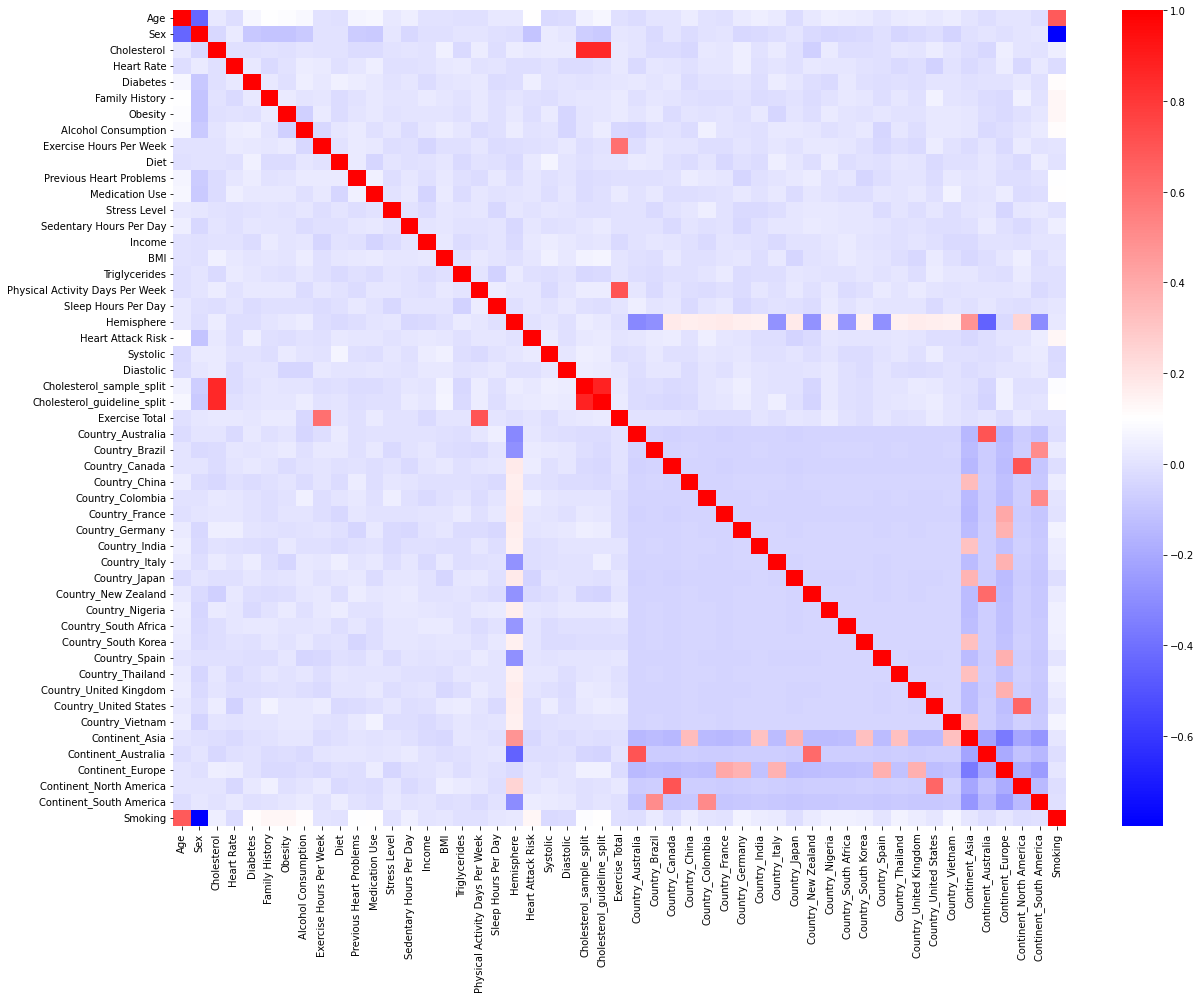

In [74]:
plt.subplots(figsize=(20, 15))

correlation_matrix = df_preprocessed.select_dtypes("number").corr()
column_names = correlation_matrix.columns
sns.heatmap(
    correlation_matrix, xticklabels=column_names, yticklabels=column_names, cmap="bwr"
);

In [75]:
# Convert the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()
corr_df.columns = ["feature_1", "feature_2", "correlation"]

# Remove self correlations
no_self_correlation = corr_df["feature_1"] != corr_df["feature_2"]
corr_df = corr_df[no_self_correlation]

# sort features so that each correlation is considered only once
corr_df["sorted_pair"] = corr_df.apply(
    lambda x: sorted([x["feature_1"], x["feature_2"]]), axis=1
)

# Drop duplicate pairs
corr_df = corr_df.drop_duplicates(subset="sorted_pair")

# Compute the absolute correlation
corr_df["absolute_correlation"] = np.abs(corr_df["correlation"])

# return top 10 correlations
top_correlations = corr_df.sort_values(by="absolute_correlation", ascending=False).head(
    20
)

top_correlations

,feature_1,feature_2,correlation,sorted_pair,absolute_correlation
1197,Cholesterol_sample_split,Cholesterol_guideline_split,0.873814,"[Cholesterol_guideline_split, Cholesterol_samp...",0.873814
126,Cholesterol,Cholesterol_guideline_split,0.859139,"[Cholesterol, Cholesterol_guideline_split]",0.859139
125,Cholesterol,Cholesterol_sample_split,0.854945,"[Cholesterol, Cholesterol_sample_split]",0.854945
101,Sex,Smoking,-0.798288,"[Sex, Smoking]",0.798288
892,Physical Activity Days Per Week,Exercise Total,0.702873,"[Exercise Total, Physical Activity Days Per Week]",0.702873
1476,Country_Canada,Continent_North America,0.701981,"[Continent_North America, Country_Canada]",0.701981
1372,Country_Australia,Continent_Australia,0.698005,"[Continent_Australia, Country_Australia]",0.698005
50,Age,Smoking,0.677810,"[Age, Smoking]",0.677810
2241,Country_United States,Continent_North America,0.641326,"[Continent_North America, Country_United States]",0.641326
1882,Country_New Zealand,Continent_Australia,0.627615,"[Continent_Australia, Country_New Zealand]",0.627615


Different measures in the data correlate with each other, especially measures of _Cholesterol_, _Exercise_ and _Geograhpic Location_ e.g. Country vs. Continent. In order to prevent data leakage, I will drop these from the features: 

In [76]:
columns_to_drop = [
    "Heart Attack Risk",
    "Cholesterol_sample_split",
    # "Cholesterol",
    "Cholesterol_guideline_split",
    "Exercise Hours Per Week",
    "Physical Activity Days Per Week",
    # "Exercise Total",
]
columns_to_drop += list(df_preprocessed.filter(regex="Country_").columns)

X_selected = df_preprocessed.drop(columns=columns_to_drop)

In [77]:
X_selected.columns

Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems',
       'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income',
       'BMI', 'Triglycerides', 'Sleep Hours Per Day', 'Hemisphere', 'Systolic',
       'Diastolic', 'Exercise Total', 'Continent_Asia', 'Continent_Australia',
       'Continent_Europe', 'Continent_North America',
       'Continent_South America', 'Smoking'],
      dtype='object')

So which features are now the most important? 

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=6
)

model_logreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Perform the permutation and unstack results (in decresing order)
permutation_score = permutation_importance(
    model_logreg, X_selected, y, n_repeats=10, random_state=10
)

importance_df = pd.DataFrame(
    np.vstack((X_selected.columns, permutation_score.importances_mean)).T
)
importance_df.columns = ["Feature", "Score Decrease"]

importance_df.sort_values(by="Score Decrease", ascending=False).head(20)

,Feature,Score Decrease
1,Sex,0.000342
7,Alcohol Consumption,0.000263
8,Diet,0.000223
9,Previous Heart Problems,0.000175
13,Income,0.000167
24,Continent_North America,0.00008
18,Systolic,0.000056
6,Obesity,0.000056
12,Sedentary Hours Per Day,0.000056
20,Exercise Total,0.000056


In [84]:
# Selecting the strongest features
X_strongest_features = X_selected[
    [
        "Sex",
        "Alcohol Consumption",
        "Diet",
        "Previous Heart Problems",
        "Income",
        "Continent_North America",
        "Systolic",
        "Obesity",
        "Sedentary Hours Per Day",
        "Exercise Total",
        "Heart Rate",
    ]
]

# Re-instantiating a Logistic Regression
log_reg = LogisticRegression()

# Average accuracy of the cross-validated model
np.mean(cross_val_score(log_reg, X_strongest_features, y, cv=10))

0.7040426477965431

So this basically did not improve the accuracy of the model at all. Let's try fine-tuning. 

### Hyperparameter Tuning with Random Search and Cross-validation

In [81]:
# Define parameter distribution
param_dist = {"C": uniform(0.1, 10), "penalty": ["l1", "l2"]}

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(
    LogisticRegression(solver="saga", max_iter=10000),
    param_dist,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_strongest_features, y, test_size=0.3, random_state=6
)

random_search.fit(X_train, y_train)

# Extract best parameters and evaluate
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [82]:
best_model

LogisticRegression(C=3.845401188473625, max_iter=10000, penalty='l1',
                   solver='saga')

So this model implies moderate regularisation (c = 3.85). Let's evaluate this model.

In [85]:
cv_scores = cross_val_score(
    best_model, X_strongest_features, y, cv=5, scoring="accuracy"
)
cv_scores.mean()

0.7040426536188431

So Random Search did not result in imporoved model fit compared to manually selecting the 7 most important features. To keep things simple and interpretable, I will then revert to the feature-reduced model and use other advanced models and regularisation to improve model fit. 

### Advanced Models

I'll give up on interpretability and just aim for performance, e.g. improve accuracy.

#### 1. XGBoost

In [88]:
# Initialize the XGBClassifier
xgb_classifier = XGBClassifier(
    max_depth=10,
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="logloss",
)

X_train, X_test, y_train, y_test = train_test_split(
    X_selected,
    y,
    test_size=0.3,
    random_state=6,
    # X_strongest_features, y, test_size=0.3, random_state=6
)

xgb_classifier.fit(X_train, y_train)


y_pred = xgb_classifier.predict(X_test)
y_prob = xgb_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
print(
    f"Accuracy: {accuracy_score(y_test, y_pred)}\n",
    f"Precision: {precision_score(y_test, y_pred)}\n",
    f"Recall: {recall_score(y_test, y_pred)}\n",
    f"F1 Score: {f1_score(y_test, y_pred)}\n",
    f"ROC-AUC: {roc_auc_score(y_test, y_prob)}",
)

Accuracy: 0.753315649867374
 Precision: 0.6672504378283712
 Recall: 0.33987511150758254
 F1 Score: 0.450354609929078
 ROC-AUC: 0.7814043910667315


Accuracy with the _X_strongest_features_ was better than a simple logistic regression model (0.7161) meaning that XGBoost improved upon the performance. However, using _X_selected_ with XGBClassifier further improved model fit to the accuracy of 0.7533 - about the same level as using all initial features (except Country and including Cholesterol as dichotomous variable instead of continous). 

So I will SVC instead to capture a data structure that other models might have missed so far, but I will return to the selected data containing almost all initial features. 

But before I do that I would like to take a look at the details of the prediction precisity. 

In [89]:
confusion_matrix(y_test, y_pred)

array([[2459,  190],
       [ 740,  381]])

Out of 3772 patients in our sample, the current (best) model correctly classifies 2840 patients, but misses 740 cases and labels 190 incorrectly as positive. 

To be honest, at this point I would prioritise Precision to be my main evaluation metrics, as it costs more not to catch a high-risk patient as to send a low-risk patient for further examinations (so sensitivity shoulod be higher than specificity). But given that the ranking metrics at Kaggle is Accuracy for this competition, I will optimise for this metric.


#### 2. Support Vector Machines

All features are scaled 0-1 (except for Diet, which is scaled as 1/2/3 but I assume equal spacing between groups). So I'll proceed with SVM. 


In [91]:
# Initialize the SVM
svm_classifier = SVC(probability=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=6
)

# Fit the XGBClassifier on the training data
svm_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = svm_classifier.predict(X_test)
y_prob = svm_classifier.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_score(y_test, y_pred)

0.73342175066313

Again, accuracy (0.733) is although better than with LogRegression, it is actually worse than using RGBoost. But I want to give a try to model fine-tuning given that SVC is better for interpretation. 

In [95]:
# Define the SVC model
svm_classifier = SVC(probability=True, max_iter=10000, verbose=False, shrinking=False)

# Define a more focused parameter distribution for RandomizedSearchCV
param_dist = {"C": [0.1, 1, 10, 100], "kernel": ["rbf"], "gamma": ["scale", "auto"]}

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=6
)

# Check if the model and outputs are already saved
try:
    best_svm_model = joblib.load("best_svm_model.pkl")
    model_outputs = joblib.load("model_outputs_svm.pkl")
    best_params = model_outputs["best_params"]
    accuracy = model_outputs["accuracy"]
    precision = model_outputs["precision"]
    recall = model_outputs["recall"]
    f1 = model_outputs["f1"]
    roc_auc = model_outputs["roc_auc"]
    conf_matrix = model_outputs["conf_matrix"]
    print("Loaded saved model and outputs.")

except FileNotFoundError:
    # Initialize RandomizedSearchCV with parallel processing using 8 cores
    rand_search = RandomizedSearchCV(
        estimator=svm_classifier,
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        scoring="accuracy",
        n_jobs=8,
        random_state=42,
    )

    # Perform RandomizedSearchCV
    rand_search.fit(X_train, y_train)

    # Get the best parameters and best estimator
    best_params = rand_search.best_params_
    best_svm_model = rand_search.best_estimator_

    # Save the best model
    joblib.dump(best_svm_model, "best_svm_model.pkl")

# Predict on the test set using the best model
y_pred = best_svm_model.predict(X_test)
y_prob = best_svm_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Save model outputs
model_outputs = {
    "best_params": best_params,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "roc_auc": roc_auc,
    "conf_matrix": conf_matrix,
}
joblib.dump(model_outputs, "model_outputs_svm.pkl")
print("Saved model and outputs.")

# Print evaluation metrics
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print("Confusion Matrix:")
print(conf_matrix)

Loaded saved model and outputs.
Saved model and outputs.
Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Accuracy: 0.7389920424403184
Precision: 0.5859473023839398
Recall: 0.41659232827832293
F1 Score: 0.4869655891553702
ROC-AUC: 0.7381401225581565
Confusion Matrix:
[[2319  330]
 [ 654  467]]


After a loooong running time the model finally converged, but accuracy only improved to 0.7389. So I will revert to XGBoost and start fine-tuning that model. 

#### 3.  XGBoost Refined

The baseline XGBoost Classifier had an Accuracy of 0.748 (and Recall/sensitivity = 0.309). Let's see if we can fine-tune a model to do better than this. 

In [96]:
# Define the XGBoost model
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],  # eta
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [1, 1.5, 2, 3],
    "scale_pos_weight": [1, 2, 3, 5, 10],
}

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=6
)


# Initialize RandomizedSearchCV with parallel processing using 8 cores
rand_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring="accuracy",
    n_jobs=8,
    random_state=42,
    verbose=0,
)

# Perform RandomizedSearchCV
rand_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = rand_search.best_params_
best_xgb_model = rand_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_xgb_model.predict(X_test)
y_prob = best_xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print evaluation metrics
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 1, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Accuracy: 0.7514588859416446
Recall: 0.33987511150758254


So the 28-feature model accuracy was slightly improved to 0.7514, but recall unfortunately dropped to 34%. For this reason I would pick the previous model in real life, but for the compatition (where models are evaluated for accuracy) I will proceed with this, hyperparameter-tuned model. Note that low recall suggests that the model misses positive (high-risk) heart attack cases. Let's see what else we can do to improve it.  

### Feature Selection 2.0

Since there are still too many (28) features in our data, I will try to reduce their number. 

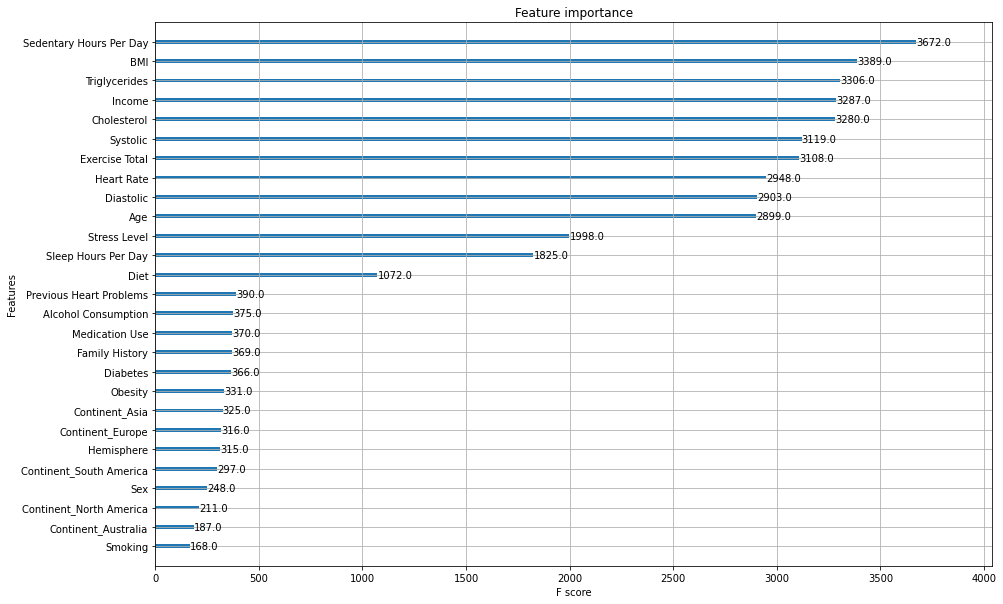

In [97]:
# Plot feature importance
plt.rcParams["figure.figsize"] = (15, 10)
plot_importance(best_xgb_model)
plt.show()

In the next step I tried to take features in and out based on their importance. But the best accuracy I could obtain was with the top24 features: 0.7453580901856764 (excluding smoking and the continents), which is still worse than leaving in all 28 features. So I will proceed with the 28-features fine-tuned XGBoost Classifier. 

### Regularisation: Elastic Net

In the next step I will attempt to improve model performance (and prevent overfitting) using Elastic Net. In order to perform this, I will use the best model parameters obtained at the last fine-tuning, then apply Randomised Search to find the optimal combination of reglularisation hyperparameters (L1 / L2). 

In [100]:
warnings.filterwarnings("ignore")  # for the final notebook

# Best parameters found by the previous RandomizedSearchCV
best_params_fixed = {
    "subsample": 1.0,
    "scale_pos_weight": 1,
    "reg_lambda": 2,
    "reg_alpha": 1,
    "n_estimators": 200,
    "max_depth": 10,
    "learning_rate": 0.1,
    "gamma": 0,
    "colsample_bytree": 0.8,
}

# Define the XGBoost model with fixed best parameters
xgb_classifier_fixed = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", **best_params_fixed
)

# Define the parameter grid for Elastic Net hyperparameters
param_dist_elastic_net = {
    "alpha": np.linspace(0, 1, 11),  # Alpha for L1 regularization (Lasso)
    "lambda": np.linspace(0, 1, 11),  # Lambda for L2 regularization (Ridge)
    "l1_ratio": np.linspace(0, 1, 11),  # Mixing parameter for Elastic Net
}

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=6
)

# Initialize RandomizedSearchCV for Elastic Net hyperparameters
rand_search_elastic_net = RandomizedSearchCV(
    estimator=xgb_classifier_fixed,
    param_distributions=param_dist_elastic_net,
    n_iter=50,
    cv=5,
    scoring="accuracy",
    n_jobs=8,
    random_state=42,
    verbose=0,
)

# Perform RandomizedSearchCV for Elastic Net hyperparameters
rand_search_elastic_net.fit(X_train, y_train)

# Get the best parameters for Elastic Net
rand_search_elastic_net.best_params_

/home/aniko/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:47:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "l1_ratio" } are not used.

  warnings.warn(smsg, UserWarning)
/home/aniko/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:47:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "l1_ratio" } are not used.

  warnings.warn(smsg, UserWarning)
/home/aniko/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:47:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "l1_ratio" } are not used.

  warnings.warn(smsg, UserWarning)
/home/aniko/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:47:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "l1_ratio" } are not used.

  warnings.warn(smsg, UserWarning)
/home/aniko/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [13:47:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "l1_rati

{'lambda': 0.0, 'l1_ratio': 0.9, 'alpha': 0.7000000000000001}

- Lambda (L2 regularization parameter): 0.0 

- L1 Ratio (mixing parameter for Elastic Net): 0.9

- Alpha (L1 regularization parameter): 0.7

These parameters suggest that the model may benefit more from Lasso (L1 regularization) than from Ridge (L2 regularization). The L1 ratio of 0.9 indicates a strong preference towards Lasso regularization. The lambda value of 0.0 suggests minimal Ridge regularization, and the alpha value of 0.7 indicates a moderate strength for Lasso regularization.

Let's use these parameters in the model, and get the accuracy: 

In [101]:
# Define the XGBoost model
xgb_classifier = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    subsample=1.0,
    scale_pos_weight=1,
    reg_lambda=0.5,
    reg_alpha=0.9,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    gamma=0,
    colsample_bytree=0.8,
)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=6
)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

Accuracy: 0.7485411140583554
Recall: 0.33719892952720787


Interestingly, after regularisation the model accuracy still did not improve. This probably happened due to the small dataset which causes the model to be sensitive to slight changes in parameters, and the small difference is actually within the range of expected variance due to random tuning. 

### Feature Selection 3.0

I will once again try to select features and run the best (fine-tuned) model to evaluate for accuracy. 

In [102]:
columns_to_drop = [
    "Heart Attack Risk",
    "Cholesterol_sample_split",
    # "Cholesterol",
    "Cholesterol_guideline_split",
    "Exercise Hours Per Week",
    "Physical Activity Days Per Week",
    # "Exercise Total",
    "Smoking",
    "Sex",
    "Hemisphere",
]

country_columns = list(df_preprocessed.filter(regex="Country_").columns)
continent_columns = list(df_preprocessed.filter(regex="Continent_").columns)

# columns_to_drop += continent_columns
columns_to_drop += country_columns
# columns_to_drop += country_columns + continent_columns

X_selected_2 = df_preprocessed.drop(columns=columns_to_drop)

X_selected_2.columns

Index(['Age', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems',
       'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income',
       'BMI', 'Triglycerides', 'Sleep Hours Per Day', 'Systolic', 'Diastolic',
       'Exercise Total', 'Continent_Asia', 'Continent_Australia',
       'Continent_Europe', 'Continent_North America',
       'Continent_South America'],
      dtype='object')

In [103]:
# Define the best XGBoost model
xgb_classifier_final = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    subsample=1.0,
    scale_pos_weight=1,
    reg_lambda=0.5,
    reg_alpha=0.9,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    gamma=0,
    colsample_bytree=0.8,
)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_2, y, test_size=0.3, random_state=6
)

# Train the model
xgb_classifier_final.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_classifier_final.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print evaluation metrics
print(
    f"Accuracy: {accuracy_score(y_test, y_pred)}\n",
    f"Precision: {precision_score(y_test, y_pred)}\n",
    f"Recall: {recall_score(y_test, y_pred)}\n",
    f"F1 Score: {f1_score(y_test, y_pred)}\n",
    f"ROC-AUC: {roc_auc_score(y_test, y_prob)}",
)

Accuracy: 0.7541114058355438
 Precision: 0.6719858156028369
 Recall: 0.33809099018733274
 F1 Score: 0.44985163204747775
 ROC-AUC: 0.7931348708835645


## FINAL MODEL


#### Final Model Evaluation

After further (manual) selection of the features, I ended up with the best accuracy score so far: 0.7541 meaning that about 75% of the time the model predictions will be correct. I still think that Recall is alarmingly low (0.34) which suggests that the model correctly identifies 34% of the actual high-risk individuals, and misses 66%. But this was not the focus of the Kaggle challenge, so I'll just ignore it. On a positiver note, when the model predicts high risk, it is correct 68% of the time (and 32% will be false alarms) which is a decent outcome. Nevertheless, the F1 score also indicates that in real life there would be room for improvement in balancing recall and precision. 

#### Final Model Visualisation

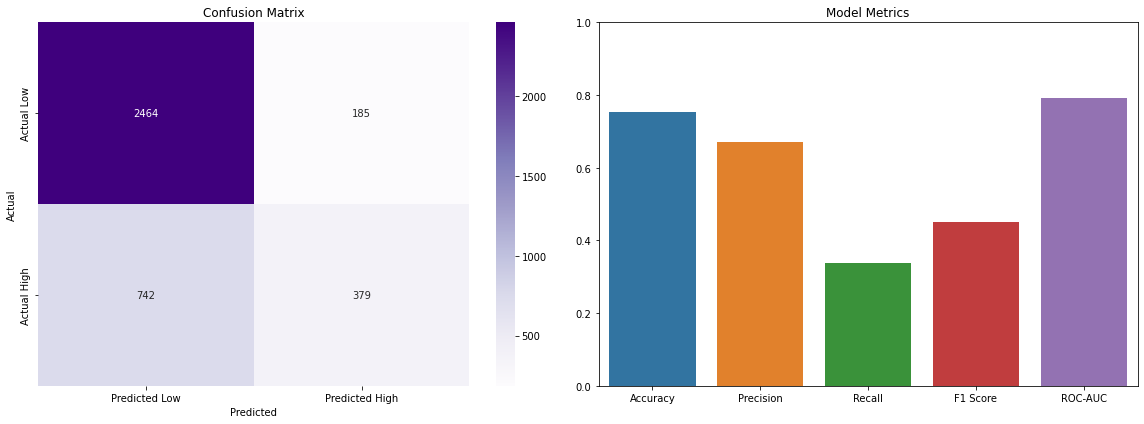

In [104]:
# Calculate metrics
conf_mtx = confusion_matrix(y_test, y_pred)
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
}

# Create a single figure with subplots
plt.figure(figsize=(16, 6))

# Plot Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(
    conf_mtx,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["Predicted Low", "Predicted High"],
    yticklabels=["Actual Low", "Actual High"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Plot Bar Plot of Metrics
plt.subplot(1, 2, 2)
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.ylim(0, 1)
plt.title("Model Metrics")

# Show plot
plt.tight_layout()
plt.show()

Out of the 3767 unknown test cases our model correctly predicts 379 positive cases, but misses 742 true positive cases! 

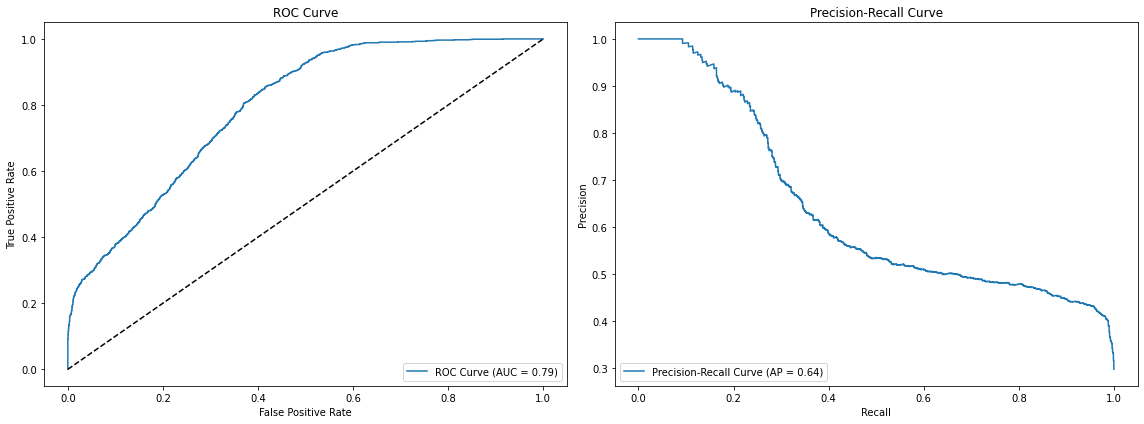

In [105]:
# ROC Curve
false_positives, true_positives, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(false_positives, true_positives, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.subplot(1, 2, 2)
plt.plot(
    recall, precision, label=f"Precision-Recall Curve (AP = {average_precision:.2f})"
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

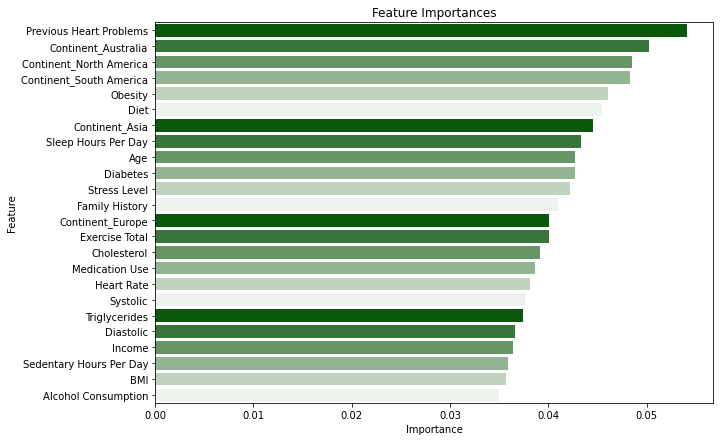

In [106]:
# Get feature importances
feature_importances = xgb_classifier_final.feature_importances_
feature_importance_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importances}
)

feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

custom_palette = sns.light_palette("darkgreen", reverse=True)

# Plot feature importances
plt.figure(figsize=(10, 7))
sns.barplot(
    x="Importance", y="Feature", data=feature_importance_df, palette=custom_palette
)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

The most predictive of heart attack risk is previous heart problems, which makes sense. This is followed by the continent, so it appears that living in Austria or in the Americas is more predictive of heart attack than diet, sleep, income or obesity. 

## PREDICT on real test data

Now that we have "the perfect" model that fits the train data, I am going to proceed with predicting the Kaggle test cases. 

### Preprocess Kaggle Test Data

In [107]:
df_raw_test = pd.read_csv("data/test.csv")  # read in test data provided by Kaggle
df_kaggletest_index = df_raw_test.set_index("Patient ID")

In [ ]:
# create new features
df_kaggletest_split = df_kaggletest_index.copy()
split_blood_pressure(df_kaggletest_split)
split_cholesterol_sample(df_kaggletest_split)
split_cholesterol_guideline(df_kaggletest_split)
exercise_total(df_kaggletest_split)

# dummy variables
df_kaggletest_encoded = df_kaggletest_split.copy()
sex_mapping = {"Male": 0, "Female": 1}
hemisphere_mapping = {"Southern Hemisphere": 0, "Northern Hemisphere": 1}

df_kaggletest_encoded["Sex"] = df_kaggletest_encoded["Sex"].map(sex_mapping)
df_kaggletest_encoded["Hemisphere"] = df_kaggletest_encoded["Hemisphere"].map(
    hemisphere_mapping
)

# categorical features
categorical_vars = ["Country", "Continent"]


df_kaggletest_encoded = pd.get_dummies(
    df_kaggletest_encoded, columns=categorical_vars, drop_first=True
)


# ordinal features

ordinal_encoder = OrdinalEncoder(categories=[["Unhealthy", "Average", "Healthy"]])

ordinal_encoder.fit(df_kaggletest_encoded[["Diet"]])
df_kaggletest_encoded["Diet"] = ordinal_encoder.transform(
    df_kaggletest_encoded[["Diet"]]
)

# continuous features to scale
df_scaled = df_encoded.copy()

continuous_vars = [
    "Age",
    "Cholesterol",
    "Heart Rate",
    "Exercise Hours Per Week",
    "Sedentary Hours Per Day",
    "Income",
    "Stress Level",
    "BMI",
    "Triglycerides",
    "Sleep Hours Per Day",
    "Physical Activity Days Per Week",
    "Systolic",
    "Diastolic",
    "Exercise Total",
]

df_kaggletest_scaled = df_kaggletest_encoded.copy()

scaler = MinMaxScaler()
df_kaggletest_scaled[continuous_vars] = scaler.fit_transform(
    df_kaggletest_scaled[continuous_vars]
)

In [110]:
# select only relevant columns
df_kaggle_preprocessed = df_kaggletest_scaled.copy()
df_kaggle_preprocessed = df_kaggle_preprocessed[X_selected_2.columns]
df_kaggle_preprocessed  # which equals to X_test

,Age,Cholesterol,Heart Rate,Diabetes,Family History,Obesity,Alcohol Consumption,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Sleep Hours Per Day,Systolic,Diastolic,Exercise Total,Continent_Asia,Continent_Australia,Continent_Europe,Continent_North America,Continent_South America
Patient ID,,,,,,,,,,,,,,,,,,,,,,,,
BMW7812,0.680556,0.314286,0.457143,0,0,0,0,1.0,0,0,0.888889,0.551990,0.862275,0.602329,0.332468,0.333333,0.755556,0.56,0.000000,0,0,0,0,1
XXM0972,0.916667,0.357143,0.957143,0,0,1,1,1.0,0,1,0.333333,0.880008,0.363753,0.191772,0.441558,0.500000,0.455556,0.16,0.147412,1,0,0,0,0
RQX1211,0.583333,0.089286,0.442857,1,0,0,1,2.0,1,0,0.777778,0.500161,0.767667,0.507348,0.281818,0.500000,0.777778,0.76,0.094951,0,0,0,1,0
RVN4963,0.375000,0.621429,0.371429,0,0,1,1,2.0,0,0,0.888889,0.584751,0.701819,0.323575,0.428571,0.333333,0.444444,0.48,0.392586,0,0,1,0,0
NCU1956,0.250000,0.046429,0.814286,1,0,1,1,2.0,1,0,1.000000,0.915054,0.725319,0.199272,0.746753,1.000000,0.788889,0.60,0.129655,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GQZ5013,0.875000,0.060714,0.300000,1,0,1,0,0.0,1,0,0.222222,0.564676,0.107677,0.776164,0.209091,1.000000,0.588889,0.08,0.173442,0,0,1,0,0
FDK8693,0.222222,0.657143,0.757143,0,1,1,1,1.0,0,0,1.000000,0.575788,0.727974,0.200713,0.988312,0.166667,0.133333,0.64,0.190887,1,0,0,0,0
SVO4635,0.791667,0.200000,0.542857,0,0,1,1,2.0,0,0,0.222222,0.553659,0.742771,0.263223,0.932468,0.666667,0.133333,0.58,0.658757,0,0,1,0,0


Above is the test dataset, where patients' risk is to be predicted.

### Train the Final Model

In order to have the  most data to the model, I will use all data (without train/test split for evaluation) for training purposes. 

In [115]:
xgb_classifier_final = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    subsample=1.0,
    scale_pos_weight=1,
    reg_lambda=0.5,
    reg_alpha=0.9,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    gamma=0,
    colsample_bytree=0.8,
)

# Train the model on all train data
xgb_classifier_final.fit(X_selected_2, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Predict on Kaggle Test Data

In [116]:
# Predict on the test set
kaggle_test_predictions = xgb_classifier_final.predict(df_kaggle_preprocessed)
kaggle_test_predictions

array([1, 0, 0, ..., 0, 0, 0])

In [117]:
df_kaggle_predicted = {
    "Patient ID": df_kaggle_preprocessed.index,
    "Heart Attack Risk": kaggle_test_predictions,
}
# predict_df = pd.DataFrame(df_kaggle_preprocessed.index, kaggle_test_predictions)
df_kaggle_predicted = pd.DataFrame(df_kaggle_predicted)
df_kaggle_predicted

,Patient ID,Heart Attack Risk
0,BMW7812,1
1,XXM0972,0
2,RQX1211,0
3,RVN4963,0
4,NCU1956,1
...,...,...
1748,GQZ5013,0
1749,FDK8693,0
1750,SVO4635,0
1751,KQR8949,0


## SAVE DATA

In [119]:
df_kaggle_predicted.to_csv("submission/df_kaggle_predicted.csv", index=False)

## Evaluation on Kaggle

With my first submission I managed to secure place 56 out of 62. Could be better, right? So in the next steps I will attempt to further improve the model. 

![img](submission/first_submission.png)